In [1]:
import nltk
import itertools
import random
import time

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("darkgrid")

In [3]:
from taggers import *
from utils import compare_taggers

In [4]:
%matplotlib inline

In [5]:
treebank_sents = list(nltk.corpus.treebank.tagged_sents())
print (len(treebank_sents))

random.shuffle(treebank_sents)

test_train_split = 3200
train_sents = treebank_sents[:test_train_split]
test_sents = treebank_sents[test_train_split:]

num_train_baseline = 200
num_tests = 500

3914


bins: 46


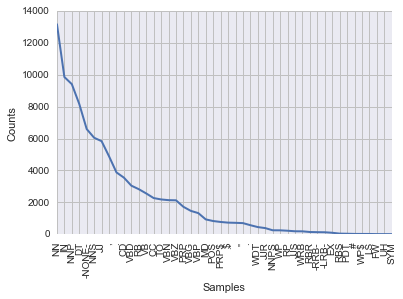

In [6]:
tags = [tag for sent in treebank_sents for (_, tag) in sent]
fd = nltk.FreqDist(tags)
print ('bins:', fd.B())
fd.plot()

bins: 11387


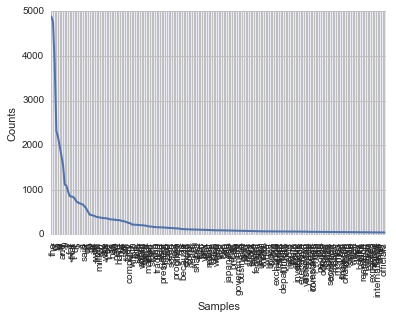

In [7]:
words = [word.lower() for sent in treebank_sents for (word, _) in sent]
fd = nltk.FreqDist(words)
print ('bins:', fd.B())
fd.plot(200)

bins: 11387
most common: [(',', 4885), ('the', 4764), ('.', 3828), ('of', 2325), ('to', 2182), ('a', 1988), ('in', 1769), ('and', 1556), ('*-1', 1123), ('0', 1099), ('*', 965), ("'s", 865), ('for', 853), ('that', 848), ('*t*-1', 806), ('*u*', 744), ('$', 718), ('``', 702), ("''", 684), ('is', 672), ('said', 628), ('it', 577), ('on', 508), ('%', 446), ('by', 440), ('at', 430), ('as', 415), ('with', 398), ('from', 391), ('million', 383), ('mr.', 375), ('*-2', 372), ('are', 369), ('was', 367), ('be', 356), ('*t*-2', 345), ('its', 343), ('has', 339), ('an', 335), ('new', 328)]


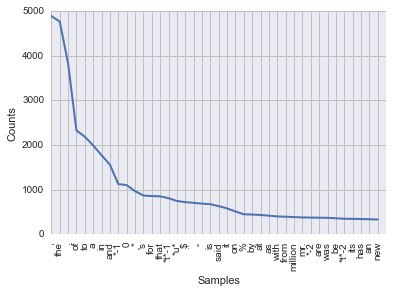

In [8]:
words = [word.lower() for sent in treebank_sents for (word, _) in sent]
#          if len(word) > 1]
fd = nltk.FreqDist(words)
print ('bins:', fd.B())
print ('most common:', fd.most_common(40))
fd.plot(40)

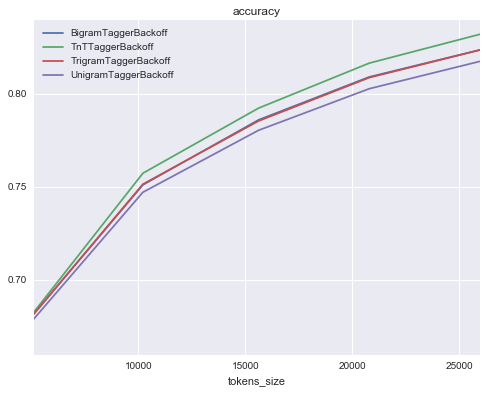

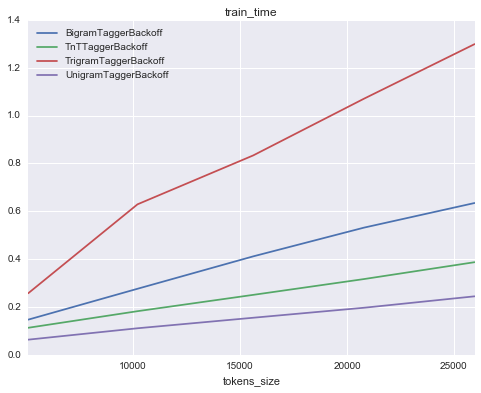

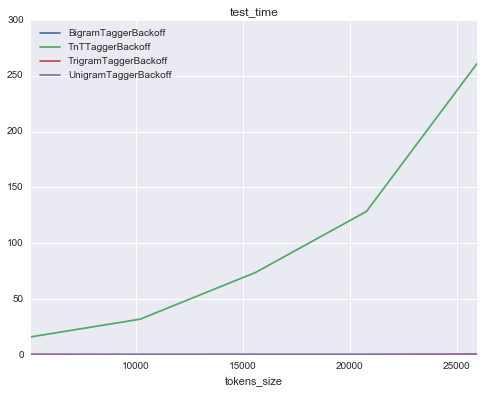

accuracy   test_time  tokens_size  train_time
tagger_type                                                              
BigramTaggerBackoff  count  5.000000    5.000000      5.00000    5.000000
                     mean   0.770554    0.210492  15534.60000    0.400214
                     std    0.056686    0.048003   8271.04838    0.194901
                     min    0.681791    0.174562   5099.00000    0.146966
                     25%    0.751360    0.194146  10208.00000    0.276119
                     50%    0.786292    0.194239  15614.00000    0.411582
                     75%    0.809384    0.194525  20789.00000    0.531660
                     max    0.823945    0.294989  25963.00000    0.634743
TnTTaggerBackoff     count  5.000000    5.000000      5.00000    5.000000
                     mean   0.776423  102.309397  15534.60000    0.249971
                     std    0.059472   98.912836   8271.04838    0.107972
                     min    0.682747   16.047403   5099.00000    0.112973
                     25%    0.757611   31.927823  10208.00000    0.182374
                     50%    0.792617   73.865770  15614.00000    0.250605
                     75%    0.816811  128.510608  20789.00000    0.316647
                     max    0.832328  261.195381  25963.00000    0.387258
TrigramTaggerBackoff count  5.000000    5.000000      5.00000    5.000000
                     mean   0.770437    0.315352  15534.60000    0.818009
                     std    0.056506    0.119190   8271.04838    0.401768
                     min    0.681865    0.217609   5099.00000    0.257267
                     25%    0.751728    0.244301  10208.00000    0.629244
                     50%    0.785704    0.248019  15614.00000    0.833668
                     75%    0.809016    0.363376  20789.00000    1.070714
                     max    0.823871    0.503457  25963.00000    1.299153
UnigramTaggerBackoff count  5.000000    5.000000      5.00000    5.000000
                     mean   0.765613    0.162809  15534.60000    0.154097
                     std    0.055134    0.051394   8271.04838    0.070889
                     min    0.679144    0.131314   5099.00000    0.063311
                     25%    0.747389    0.137446  10208.00000    0.110959
                     50%    0.780703    0.139004  15614.00000    0.154948
                     75%    0.803059    0.152592  20789.00000    0.196727
                     max    0.817767    0.253689  25963.00000    0.244541

In [9]:
tagger_classes = [TnTTaggerBackoff, TrigramTaggerBackoff,
                  BigramTaggerBackoff, UnigramTaggerBackoff]
grouped = compare_taggers(tagger_classes, train_sents, test_sents,
                          num_train_baseline, num_tests)
grouped.describe()

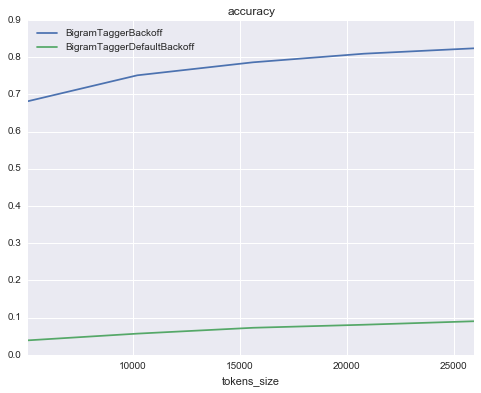

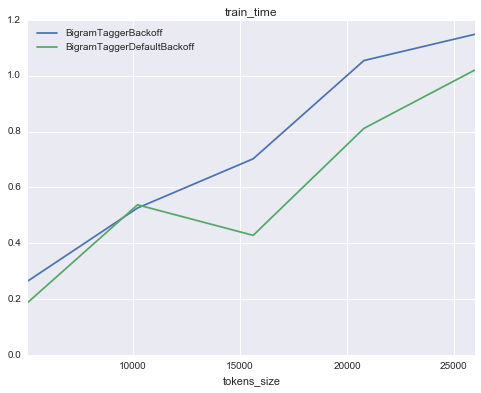

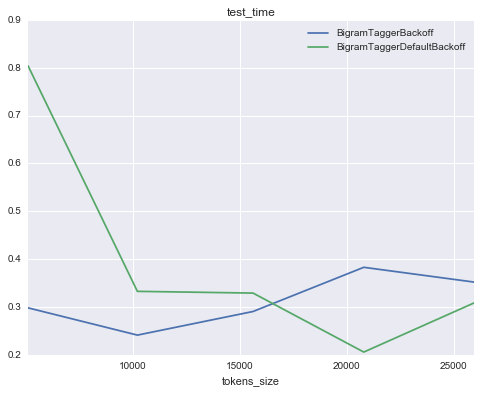

accuracy  test_time  tokens_size  train_time
tagger_type                                                                   
BigramTaggerBackoff        count  5.000000   5.000000      5.00000    5.000000
                           mean   0.770554   0.312933  15534.60000    0.739425
                           std    0.056686   0.055433   8271.04838    0.366875
                           min    0.681791   0.241155   5099.00000    0.265311
                           25%    0.751360   0.290547  10208.00000    0.526104
                           50%    0.786292   0.298119  15614.00000    0.702527
                           75%    0.809384   0.351920  20789.00000    1.054640
                           max    0.823945   0.382923  25963.00000    1.148541
BigramTaggerDefaultBackoff count  5.000000   5.000000      5.00000    5.000000
                           mean   0.067907   0.396068  15534.60000    0.597291
                           std    0.020309   0.233901   8271.04838    0.325436
                           min    0.038903   0.205721   5099.00000    0.188968
                           25%    0.056920   0.308835  10208.00000    0.428178
                           50%    0.072658   0.329036  15614.00000    0.537615
                           75%    0.080821   0.332657  20789.00000    0.811466
                           max    0.090234   0.804092  25963.00000    1.020227

In [10]:
tagger_classes = [BigramTaggerBackoff, BigramTaggerDefaultBackoff]
grouped = compare_taggers(tagger_classes, train_sents, test_sents,
                          num_train_baseline, num_tests)
grouped.describe()

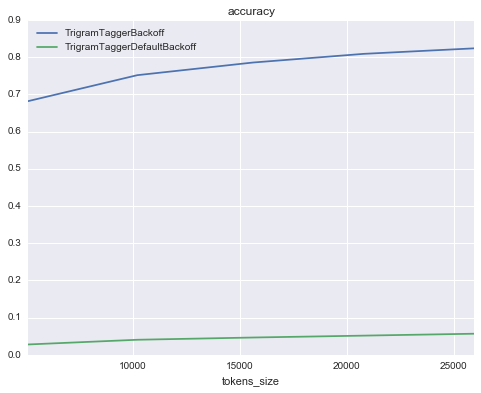

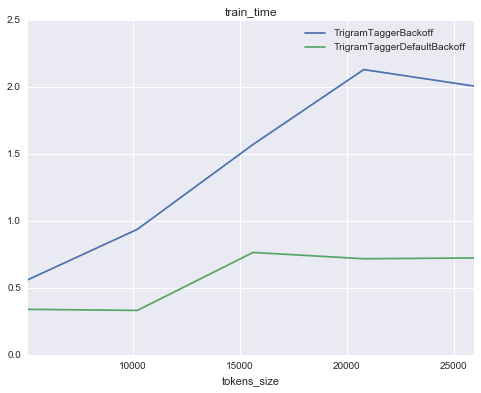

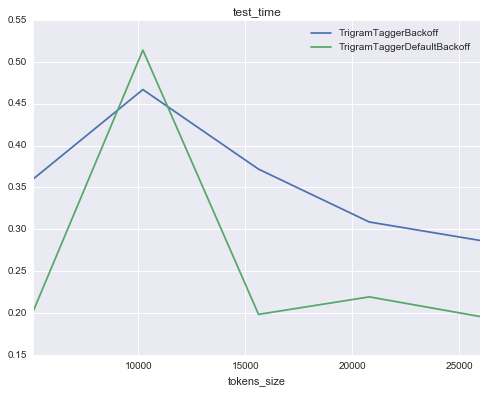

accuracy  test_time  tokens_size  \
tagger_type                                                           
TrigramTaggerBackoff        count  5.000000   5.000000      5.00000   
                            mean   0.770437   0.358874  15534.60000   
                            std    0.056506   0.069948   8271.04838   
                            min    0.681865   0.286645   5099.00000   
                            25%    0.751728   0.308671  10208.00000   
                            50%    0.785704   0.360379  15614.00000   
                            75%    0.809016   0.371803  20789.00000   
                            max    0.823871   0.466874  25963.00000   
TrigramTaggerDefaultBackoff count  5.000000   5.000000      5.00000   
                            mean   0.044595   0.266080  15534.60000   
                            std    0.011156   0.138906   8271.04838   
                            min    0.027798   0.195747   5099.00000   
                            25%    0.040447   0.198281  10208.00000   
                            50%    0.046477   0.203149  15614.00000   
                            75%    0.051552   0.219196  20789.00000   
                            max    0.056700   0.514026  25963.00000   

                                   train_time  
tagger_type                                    
TrigramTaggerBackoff        count    5.000000  
                            mean     1.440897  
                            std      0.677971  
                            min      0.561043  
                            25%      0.937154  
                            50%      1.570526  
                            75%      2.006000  
                            max      2.129761  
TrigramTaggerDefaultBackoff count    5.000000  
                            mean     0.575122  
                            std      0.219517  
                            min      0.331642  
                            25%      0.339352  
                            50%      0.717180  
                            75%      0.723102  
                            max      0.764336

In [11]:
tagger_classes = [TrigramTaggerBackoff, TrigramTaggerDefaultBackoff]
grouped = compare_taggers(tagger_classes, train_sents, test_sents,
                          num_train_baseline, num_tests)
grouped.describe()